<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer 

import torch
import transformers as ppb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('toxic_comments.csv')
#data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Слишком много наблюдений, предлагаю взять рандомно 4000 строк

In [5]:
half_1 = data[data['toxic'] == 0].sample(2000)
half_2 = data[data['toxic'] == 1].sample(2000)

batch = pd.concat([half_1, half_2], ignore_index=True)

In [6]:
batch['toxic'].value_counts()

0    2000
1    2000
Name: toxic, dtype: int64

In [7]:
batch.head()

,text,toxic
0,OK DUDE SHE's not in there\nif you're doin ap...,0
1,"""::::::::There's another good section of WP:V,...",0
2,well done. \n\nWay to repress the freedom of e...,0
3,nor anyone else. Apparently this person percei...,0
4,How can he be done? He hasn't even pointed ou...,0


Если брать случайную выборку, получается сильный дисбаланс (и соответственно, плохие результаты). Не знаю точно, насколько законно то, что я вытащил ровно по тысяче и того, и того, но теперь все гораздо лучше)

Подготовим текст: отбросим лишние символы, проведем лемматизацию

In [8]:
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    
    return ' '.join([lemmatizer.lemmatize(x) for x in word_list])

In [9]:
def clear_text(text):
    return ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split())

In [10]:
batch['text'] = batch['text'].apply(clear_text)

In [11]:
%%time

nltk.download('omw-1.4')
batch['text'] = batch['text'].apply(lemmatize)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Khorz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


CPU times: total: 2.64 s
Wall time: 2.76 s


In [12]:
batch.head()

,text,toxic
0,OK DUDE SHE s not in there if you re doin apri...,0
1,There s another good section of WP V one of th...,0
2,well done Way to repress the freedom of expres...,0
3,nor anyone else Apparently this person perceiv...,0
4,How can he be done He hasn t even pointed out ...,0


Текст подготовлен

Загружаем предобученную модель DistilBert и токенизатора (как понял, DistilBert более легкая и быстрая версия Bert, результат будет чуть хуже)

In [13]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

Загружаем предобученную модель/токенизатор

In [14]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Токенезируем нашу выборку
(далее будет с картинками, это я для себя на будущее))

In [15]:
tokenized = batch['text'].apply((lambda x: tokenizer.encode(x, truncation=True, max_length=100, add_special_tokens=True)))

Вот, что здесь произошло:
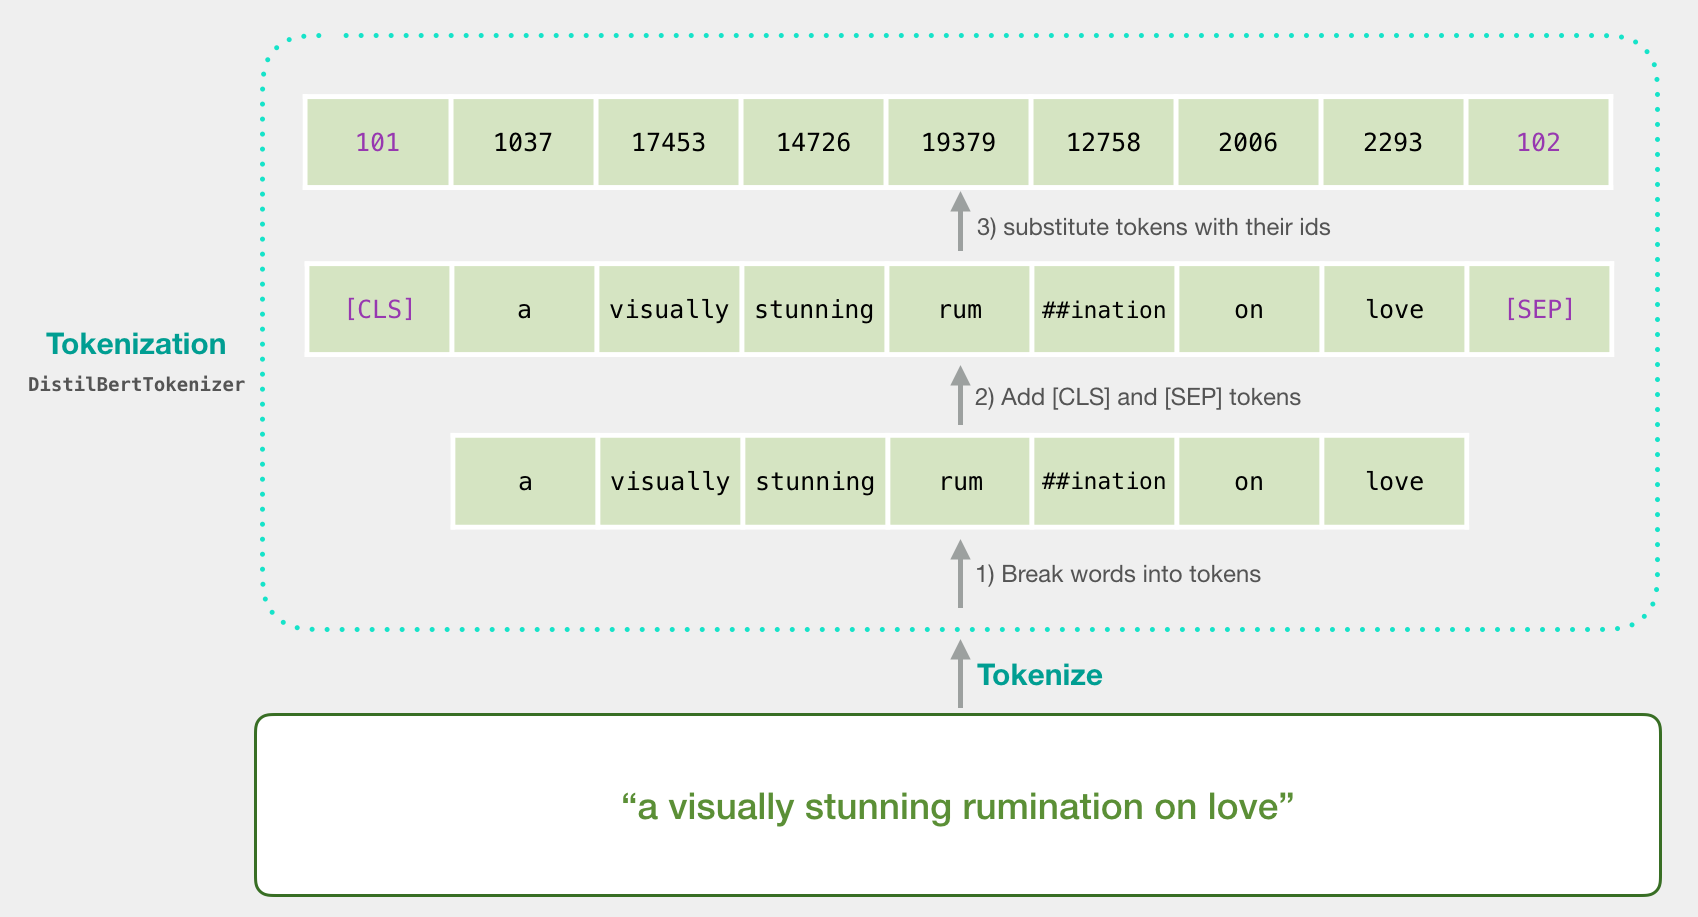

Padding (делаем все вектора одного размера, заполняем нулями)

In [16]:
max_len = 0
for x in tokenized.values:
    if len(x) > max_len:
        max_len = len(x)
        
padded = np.array([x + [0]*(max_len-len(x)) for x in tokenized.values])

Маскируем созданные нули

In [17]:
attention_mask = np.where(padded != 0, 1, 0)

In [18]:
attention_mask.shape

(4000, 100)

Делаем из padded и attention_mask тензоры (вроде как) и закидываем их в модель

In [19]:
%%time

input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

CPU times: total: 25min 18s
Wall time: 4min 16s


Поскольку у нас задача классификации, нам не нужны все элементы матрицы  last_hidden_states. BERT в начале предложения создает токен [CLS], который нужен для классификации всего предложения. Поэтому оставляем только первый элемент

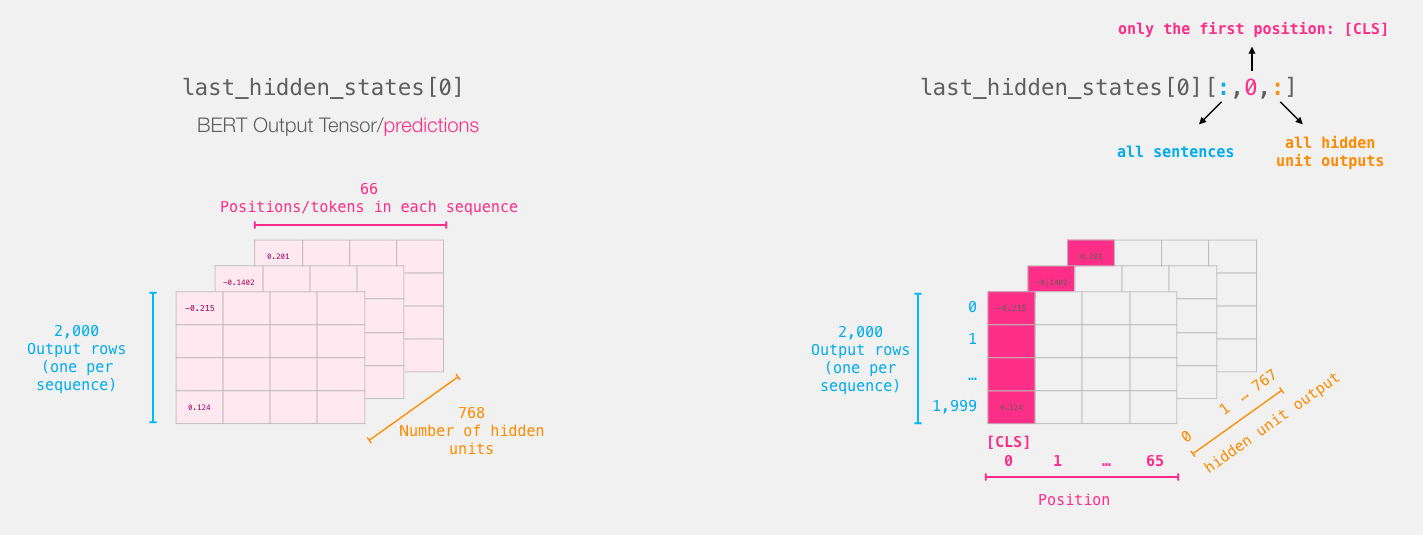

In [20]:
features = last_hidden_states[0][:,0,:].numpy()

Получили новые фичи, дальше будет попривычнее

## Обучение

In [21]:
X_train, X_test, y_train, y_test = train_test_split(features, batch['toxic'], test_size=0.2)

Перебираем модели

In [22]:
%%time 

MLA = [
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LGBMClassifier()
]

row_index = 0


MLA_cols = ['Model', 'F1']
MLA_compare = pd.DataFrame(columns = MLA_cols)


for model in MLA:
    MLA_compare.loc[row_index, 'Model'] = model.__class__.__name__
    cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring='f1')
    MLA_compare.loc[row_index, 'F1'] = cv_results.mean()
    
    row_index+=1


MLA_compare.sort_values(by=['F1'], ascending=False, inplace=True)
MLA_compare

CPU times: total: 5min 16s
Wall time: 1min 30s


,Model,F1
0,LogisticRegression,0.877272
4,LGBMClassifier,0.87073
3,RandomForestClassifier,0.849046
1,KNeighborsClassifier,0.828464
2,DecisionTreeClassifier,0.756886


Поперебираем параметре в нескольких моделях

In [23]:
# %%time

# parameters = {'C': np.linspace(0.0001, 100, 20)}
# grid_search = GridSearchCV(LogisticRegression(), parameters, scoring='f1')
# grid_search.fit(X_train, y_train)

# print('best parameters: ', grid_search.best_params_)
# print('best scrores: ', grid_search.best_score_)

LGBM выдал f1 = 84.22 с параметром: {'C': 5.263252631578947}

In [24]:
# %%time

# lgbm = LGBMClassifier()

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 20)]
# max_depth = [int(x) for x in np.linspace(5, 30, num = 10)]
# num_leaves = [int(x) for x in np.linspace(50, 200, num=20)]


# param_grid = {
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'num_leaves': num_leaves,
# }

# rf_random = RandomizedSearchCV(estimator = lgbm, 
#                                param_distributions = param_grid, 
#                                n_iter = 30,
#                                cv = 5, 
#                                verbose=2, 
#                                random_state=42,
#                                scoring='f1',
#                                n_jobs = -1)

# rf_random.fit(X_train, y_train)
# print(rf_random.best_score_)
# print(rf_random.best_params_)

LGBM выдал f1 = 86.46 с параметрами: {'num_leaves': 121, 'n_estimators': 952, 'max_depth': 7}

In [25]:
# %%time

# forest = RandomForestClassifier()


# random_grid = {'bootstrap': [True, False],
#                'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
#                'max_features': ['auto', 'sqrt'],
#                'min_samples_leaf': [1, 2, 4],
#                'min_samples_split': [2, 5, 10],
#                'n_estimators': [130, 180, 230]
#               }

# rf_random = RandomizedSearchCV(estimator = forest, 
#                                param_distributions = random_grid, 
#                                n_iter = 20,
#                                cv = 5, 
#                                verbose=2, 
#                                random_state=42,
#                                scoring='f1',
#                                n_jobs = -1)

# rf_random.fit(X_train, y_train)
# print(rf_random.best_score_)
# print(rf_random.best_params_)

Лес выдал f1 = 85.4 с параметрами: {'n_estimators': 230, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

In [26]:
# %%time

# knr = KNeighborsClassifier()

# n_neighbours = [int(x) for x in np.linspace(start = 5, stop = 15, num = 10)]

# param_grid = {
#     'n_neighbors': n_neighbours,
#     'weights': ['uniform', 'distance'],
#     'algorithm': ['auto', 'ball_tree']
# }

# rf_random = RandomizedSearchCV(estimator = knr, 
#                                param_distributions = param_grid, 
#                                n_iter = 50,
#                                cv = 5, 
#                                verbose=2, 
#                                random_state=42,
#                                scoring='f1',
#                                n_jobs = -1)

# rf_random.fit(X_train, y_train)
# print(rf_random.best_score_)
# print(rf_random.best_params_)

Соседи выдали f1 = 84.01 с параметрами: {'weights': 'uniform', 'n_neighbors': 15, 'algorithm': 'auto'}

Сравним модели с новыми параметрами на тестовой выборке

In [27]:
%%time


MLA = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=230, 
                          min_samples_split=5, 
                          min_samples_leaf=1, 
                          max_features='sqrt', 
                          max_depth=20, 
                          bootstrap=True),
    LGBMClassifier(num_leaves=121, n_estimators=952, max_depth=7),
    KNeighborsClassifier(weights='uniform', n_neighbors=15, algorithm='auto'),
]

row_index = 0

# Создаем таблицу для сравнения моделей
MLA_cols = ['Model', 'F1']
MLA_compare = pd.DataFrame(columns = MLA_cols)

# Добавляем метрики и время в таблицу
for model in MLA:
    MLA_compare.loc[row_index, 'Model'] = model.__class__.__name__      
    predictions = model.fit(X_train, y_train).predict(X_test)
    MLA_compare.loc[row_index, 'F1'] = f1_score(y_test, predictions)
    
    row_index+=1

# Результаты
MLA_compare.sort_values(by=['F1'], ascending=False, inplace=True)
MLA_compare

CPU times: total: 2min
Wall time: 23.6 s


,Model,F1
3,LGBMClassifier,0.891443
2,RandomForestClassifier,0.886598
0,LogisticRegression,0.884076
4,KNeighborsClassifier,0.855758
1,DecisionTreeClassifier,0.739659


## Выводы

С помощью нейросети BERT были созданы признаки для последующего обучения модели. Были рассмотрены 5 моделей, лучшую метрику f1 показала модель градиентного бустинга с параметрами: {'num_leaves': 121, 'n_estimators': 952, 'max_depth': 7}

In [28]:
MLA_compare

,Model,F1
3,LGBMClassifier,0.891443
2,RandomForestClassifier,0.886598
0,LogisticRegression,0.884076
4,KNeighborsClassifier,0.855758
1,DecisionTreeClassifier,0.739659


Стоит отметить, что в силу экономии ресурсов и времени рассматривалась лишь малая часть данных (около 1.25%).